## B&S simple classical generator

This file can be used to reproduce Figure 6 of the manuscript

Where we train a generator state $U_G (\theta_G) \vert 0 \rangle$ with a quantum discriminator.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

import jax
from jax import numpy as jnp
import optax

from functools import partial
from flax.training import train_state 
from Bars_and_Stripes_Loader import BASDataset, NumpyLoader
from Jax_Circuit_helper import circuit_to_execute_D, Full_Model, QNN, linear_QNN, get_percentage_of_samples, get_percentage_of_dataset
from Ising_data_helper import generate_1D_chain_graph, get_Hamiltonian
from binary_data_helper import dec2bin

/Users/patrickhuembeli/anaconda3/envs/TNandJAX/lib/python3.9/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


## Define all Variables

In [2]:
batch_size = 8 # Batch size (for how many data points is D trained at a time)
noise_batch = 16 # Noise batch size (for how many noise inputs is the full model trained at a time)

n_work = 6  # Number of qubits used for data encoding
auxiliary_D = 4  # Nr of auxiliary qubits for discriminator
auxiliary_G = 0  # Nr of auxiliary for the generator (set to zero for the classical psi_G)
n_total = n_work + auxiliary_D
depth_D = 40 # depth of D
depth_G = 20 # depth of G

n_critic = 5 # number of D updates until G update
lrG = 0.01  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 20001  # Number of training iterations
size_dataset = 8 # how big is the training data
low_high_energy_split = 0.25 # how many states of the spectrum will be included? 1 --> all, 0.1 --> 10% lowest energy

noise_reupload = True # Do we do reuploading or just use a noise input at the beginning of the circuit

shots = 20 # we only need samples during training to visualize progress. Nr of shots not relevant

n_samples = 10000 # nr of samples for histogram per noise

noise_dim = 2 # how big is noise input to the NN

seed = 1 # random seed
key = jax.random.PRNGKey(seed) # initialize pseudo random number generator
_, subkey = jax.random.split(key)

## Generate Ising Data and create Dataloader

In [8]:
J_list = generate_1D_chain_graph(n_work)
H = get_Hamiltonian(n_work, J_list)
vals, vecs= np.linalg.eigh(H)

V = vecs.T # transpose because of numpy eigh convention psi_0 = vecs[:, 0] 
_, indices = np.where(V > 0.9 ) # check where the eigenstates are 1.
decimal_states = indices # If an eigenstate is 1 at index n, then the corresponding spin config is n in binary representation
binary_states = dec2bin(decimal_states, n_work)
X_split = binary_states[0:int(len(binary_states)*low_high_energy_split)]
np.random.seed(seed)
idx = np.random.choice(range(len(X_split)), size=(size_dataset), replace=False)
X = X_split[idx]

dataloader = NumpyLoader(X, batch_size=batch_size, shuffle=True)

## Define the pennylane Qnodes

We define the quantum discriminator, the quantum generator and the full model which takes an input state $\vert \psi_G \rangle$ and inputs it into the discriminator.

In [9]:
dev_D = qml.device("default.qubit.jax", wires=n_work + auxiliary_D)
dev_G = qml.device("default.qubit.jax", wires=n_work + auxiliary_G)
dev_total = qml.device("default.qubit.jax", wires=n_work+auxiliary_D+auxiliary_G)

discriminator = qml.QNode(partial(circuit_to_execute_D, depth_D=depth_D, 
                                  n_work = n_work, 
                                  auxiliary_D = auxiliary_D), 
                          dev_D, interface = "jax", diff_method="backprop")

full_model = qml.QNode(partial(Full_Model, depth_D=depth_D,
                               n_work = n_work, 
                               auxiliary_D = auxiliary_D, auxiliary_G = auxiliary_G), 
                       dev_total, interface = "jax", diff_method="backprop")

if noise_reupload == True:
        Generator = qml.QNode(partial(QNN, n_layers=depth_G, 
                                        n_total = n_work + auxiliary_G), 
                                dev_G, interface = "jax", diff_method="backprop")
else:
        Generator = qml.QNode(partial(linear_QNN, n_layers=depth_G, 
                                        n_total = n_work + auxiliary_G), 
                                dev_G, interface = "jax", diff_method="backprop")


D_vmap = jax.vmap(discriminator, in_axes=(0, None))
full_model_vmap = jax.vmap(full_model, in_axes=(0, None))
generator = jax.vmap(Generator, in_axes = (0, None))

## Define Train States and Training Loop

In [10]:
def create_train_state_G(subkey, learning_rate):
    """Creates initial `TrainState`."""
    weights_G = jax.random.uniform(subkey, (depth_G , n_work + auxiliary_G , 3), dtype = np.float32)     
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=D_vmap, params=weights_G, tx=tx) # there is no apply_fn, D_vmap is just dummy

def create_train_state_circuit(subkey, learning_rate):
    """Creates initial `TrainState`."""
    weights_D = jax.random.uniform(subkey, (depth_D , (n_work + auxiliary_D), 3), dtype = np.float32)  
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=D_vmap, params=weights_D, tx=tx) # there is no apply_fn, D_vmap is just dummy


@jax.jit
def train_step_D(state_D, state_G, data, noise):
    def pred_real(weights_D, data):
        pred = D_vmap(data, weights_D)
        pred = (pred+1.)/2.
        return pred.mean()

    def pred_fake(weights_G, weights_D, noise):
        state_G = generator(noise, weights_G)
        pred = full_model_vmap(state_G, weights_D)
        pred = (pred+1.)/2
        return pred.mean()

    def W_loss_D(weights_G, weights_D, noise, data):
        pred_f = pred_fake(weights_G, weights_D, noise)
        pred_r = pred_real(weights_D, data)
        return pred_f - pred_r

    grad_fn = jax.value_and_grad(W_loss_D, argnums = 1)
    loss, grads = grad_fn(state_G.params, state_D.params, noise, data)
    state_D = state_D.apply_gradients(grads=grads)
    return state_D, loss

@jax.jit
def train_step_G(state_D, state_G, noise):
    def pred_fake(weights_G, weights_D, noise):
        state_G = generator(noise, weights_G)
        pred = full_model_vmap(state_G, weights_D)
        pred = (pred+1.)/2
        return pred.mean()

    def W_loss_G(weights_G, weights_D, noise):
        pred_f = pred_fake(weights_G, weights_D, noise)
        return -pred_f
    
    grad_fn = jax.value_and_grad(W_loss_G, argnums = 0)
    loss, grads = grad_fn(state_G.params, state_D.params, noise)
    state_G = state_G.apply_gradients(grads=grads)
    return state_G, loss

def train_run(state_D, state_G, subkey, num_iter):
    history_D = []
    history_G = []
    for i in range(num_iter):    
        _, data = next(enumerate(dataloader))
        if noise_reupload == False: # If we have linear noise
            n = (jax.random.uniform(subkey, (noise_batch, noise_dim), dtype = np.float32) - 0.5)*2
            noise = jnp.concatenate([n]*(n_work//noise_dim), axis=1)
        else:
            n = (jax.random.uniform(subkey, (noise_batch, noise_dim))-0.5)*2
            noise = jnp.zeros((noise_batch, 3))
            noise = noise.at[:, 0:noise_dim].set(n)
        
        _, subkey = jax.random.split(subkey)
        state_D, lossD = train_step_D(state_D, state_G, data, noise)
        history_D.append(lossD.item())
        
        if i%n_critic == 0 and i!= 0:
            state_G, lossG = train_step_G(state_D, state_G, noise)
            history_G.append(lossG.item())
        
        if i % 50 == 0 and i!=0:
            print(f'Iteration: {i}, Discriminator Loss: {lossD:0.3f}, Generator Loss: {lossG:0.3f}')
    return state_D, state_G, history_G, history_D

## Run Training

In [11]:
jax_state_G = create_train_state_G(subkey, lrG)
jax_state_D = create_train_state_circuit(subkey, lrD)
jax_state_D, jax_state_G, history_G, history_D = train_run(jax_state_D, jax_state_G, subkey, num_iter)

/Users/patrickhuembeli/anaconda3/envs/TNandJAX/lib/python3.9/site-packages/autoray/autoray.py:348: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(dtype, **kwargs)
2022-09-13 18:57:16.334379: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_train_step_D.21] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-09-13 19:01:19.095400: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 6m2.76427s

********************************
[Compiling module j

Iteration: 50, Discriminator Loss: -0.506, Generator Loss: -0.397
Iteration: 100, Discriminator Loss: -0.433, Generator Loss: -0.507
Iteration: 150, Discriminator Loss: -0.409, Generator Loss: -0.529
Iteration: 200, Discriminator Loss: -0.451, Generator Loss: -0.483
Iteration: 250, Discriminator Loss: -0.418, Generator Loss: -0.486
Iteration: 300, Discriminator Loss: -0.410, Generator Loss: -0.508
Iteration: 350, Discriminator Loss: -0.449, Generator Loss: -0.457
Iteration: 400, Discriminator Loss: -0.491, Generator Loss: -0.409
Iteration: 450, Discriminator Loss: -0.428, Generator Loss: -0.484
Iteration: 500, Discriminator Loss: -0.468, Generator Loss: -0.454
Iteration: 550, Discriminator Loss: -0.509, Generator Loss: -0.422
Iteration: 600, Discriminator Loss: -0.501, Generator Loss: -0.443
Iteration: 650, Discriminator Loss: -0.509, Generator Loss: -0.438
Iteration: 700, Discriminator Loss: -0.462, Generator Loss: -0.482
Iteration: 750, Discriminator Loss: -0.500, Generator Loss: -0.

/Users/patrickhuembeli/anaconda3/envs/TNandJAX/lib/python3.9/site-packages/autoray/autoray.py:348: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(dtype, **kwargs)
/Users/patrickhuembeli/anaconda3/envs/TNandJAX/lib/python3.9/site-packages/pennylane/_qubit_device.py:652: UserWarning: Explicitly requested dtype <class 'numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return (states_sampled_base_ten > 0).astype(dtype)[:, ::-1]


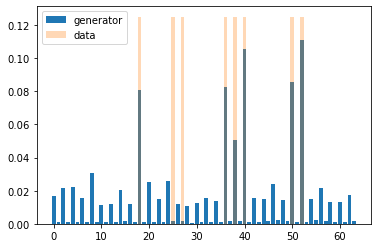

In [14]:
if noise_reupload == False: # If we have linear noise
    n = (jax.random.uniform(subkey, (noise_batch, noise_dim), dtype = np.float32) - 0.5)*2
    noise = jnp.concatenate([n]*(n_work//noise_dim), axis=1)
else:
    n = (jax.random.uniform(subkey, (100, noise_dim))-0.5)*2.
    noise = jnp.zeros((100, 3))
    noise = noise.at[:, 0:noise_dim].set(n)


state_G = generator(noise, jax_state_G.params)
n_samples = 10000
percentage = np.array(get_percentage_of_samples(state_G, subkey, n_samples, n_work, auxiliary_G = auxiliary_G))
percentage2 = np.array(get_percentage_of_dataset(X, n_work))

plt.bar(range(len(percentage)), percentage, label="generator")
plt.bar(range(len(percentage2)), percentage2, label="data", alpha = 0.3)
plt.legend()
plt.show()


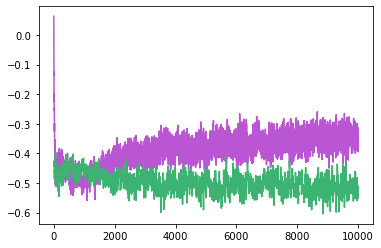

In [15]:
plt.plot(range(num_iter), history_D, label = "loss D", color = "mediumorchid")
plt.plot(range(n_critic, num_iter, n_critic), history_G, label = "loss G", color = "mediumseagreen")